       Algorithm     Preprocessing  Clusters  Silhouette Score  \
0        K-Means          Original         3          0.551192   
1        K-Means          Original         4          0.497643   
2        K-Means          Original         5          0.493080   
3        K-Means        Normalized         3          0.479881   
4        K-Means        Normalized         4          0.385045   
5        K-Means        Normalized         5          0.345033   
6        K-Means               PCA         3          0.597676   
7        K-Means               PCA         4          0.557741   
8        K-Means               PCA         5          0.510041   
9        K-Means  Normalized + PCA         3          0.522791   
10       K-Means  Normalized + PCA         4          0.445187   
11       K-Means  Normalized + PCA         5          0.411085   
12  Hierarchical          Original         3          0.554324   
13  Hierarchical          Original         4          0.488967   
14  Hierar

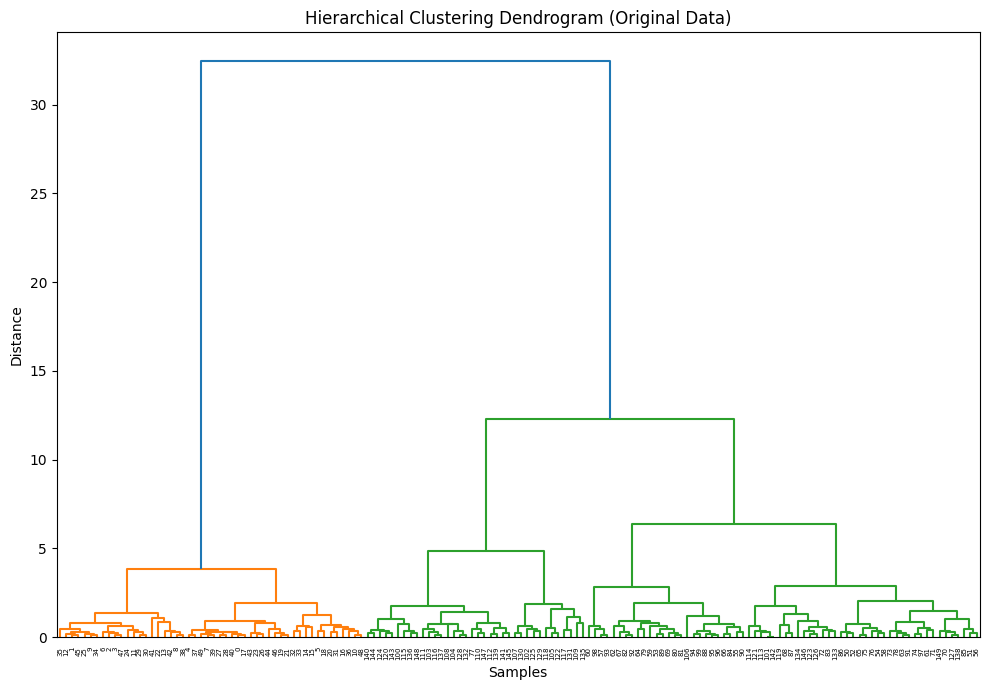

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

iris = load_iris()
X_original = iris.data
y_true = iris.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
X_pca_only = PCA(n_components=2).fit_transform(X_original)
X_scaled_pca = PCA(n_components=2).fit_transform(X_scaled)

datasets = [
    ("Original", X_original),
    ("Normalized", X_scaled),
    ("PCA", X_pca_only),
    ("Normalized + PCA", X_scaled_pca)
]

def get_clustering_scores(X, labels):
    return (
        silhouette_score(X, labels),
        calinski_harabasz_score(X, labels),
        davies_bouldin_score(X, labels)
    )

evaluation_metrics = {
    "Algorithm": [],
    "Preprocessing": [],
    "Clusters": [],
    "Silhouette Score": [],
    "Calinski-Harabasz": [],
    "Davies-Bouldin": []
}

for label, data in datasets:
    for k in [3, 4, 5]:
        model = KMeans(n_clusters=k, random_state=42).fit(data)
        sil, cal, db = get_clustering_scores(data, model.labels_)
        evaluation_metrics["Algorithm"].append("K-Means")
        evaluation_metrics["Preprocessing"].append(label)
        evaluation_metrics["Clusters"].append(k)
        evaluation_metrics["Silhouette Score"].append(sil)
        evaluation_metrics["Calinski-Harabasz"].append(cal)
        evaluation_metrics["Davies-Bouldin"].append(db)

for label, data in datasets:
    linkage_mat = linkage(data, method="ward")
    for k in [3, 4, 5]:
        cluster_labels = fcluster(linkage_mat, t=k, criterion='maxclust')
        sil, cal, db = get_clustering_scores(data, cluster_labels)
        evaluation_metrics["Algorithm"].append("Hierarchical")
        evaluation_metrics["Preprocessing"].append(label)
        evaluation_metrics["Clusters"].append(k)
        evaluation_metrics["Silhouette Score"].append(sil)
        evaluation_metrics["Calinski-Harabasz"].append(cal)
        evaluation_metrics["Davies-Bouldin"].append(db)

for label, data in datasets:
    bandwidth = estimate_bandwidth(data, quantile=0.2)
    meanshift_model = MeanShift(bandwidth=bandwidth).fit(data)
    cluster_labels = meanshift_model.labels_
    sil, cal, db = get_clustering_scores(data, cluster_labels)
    evaluation_metrics["Algorithm"].append("Mean-Shift")
    evaluation_metrics["Preprocessing"].append(label)
    evaluation_metrics["Clusters"].append(len(np.unique(cluster_labels)))
    evaluation_metrics["Silhouette Score"].append(sil)
    evaluation_metrics["Calinski-Harabasz"].append(cal)
    evaluation_metrics["Davies-Bouldin"].append(db)

results_df = pd.DataFrame(evaluation_metrics)
results_df.to_csv("clustering_results.csv", index=False)
print(results_df)

plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram (Original Data)")
dendrogram(linkage(X_original, method='ward'))
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()